# Data Exploration

In [1]:
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import sys
import os

# Add project root to path
sys.path.append(os.path.abspath(".."))

np.random.seed(42)

In [2]:
df = pd.read_parquet('../data/train.parquet')
df.sample(5)

,status,gender,firstName,level,lastName,userId,ts,auth,page,sessionId,location,itemInSession,userAgent,method,length,song,artist,time,registration
8415245,200,M,August,paid,Clark,1207487,1540518498000,Logged In,NextSong,112798,"Riverside-San Bernardino-Ontario, CA",400,Mozilla/5.0 (Windows NT 6.1; Trident/7.0; rv:1...,PUT,236.04200,Hostile [Live Version],Pantera,2018-10-26 01:48:18,2018-09-10 17:03:47
12828473,200,F,Alani,paid,Kane,1325330,1541672419000,Logged In,NextSong,159518,"Tampa-St. Petersburg-Clearwater, FL",74,Mozilla/5.0 (Windows NT 6.1; rv:31.0) Gecko/20...,PUT,194.03710,Karibien,Air France,2018-11-08 10:20:19,2018-09-05 06:02:19
13490632,200,F,Angelina,paid,Singh,1495032,1541826321000,Logged In,NextSong,174513,"Santa Maria-Santa Barbara, CA",216,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",PUT,278.07302,Through The Wire,Kanye West,2018-11-10 05:05:21,2018-08-24 13:24:27
9329450,200,M,Nathaniel,paid,Norris,1525270,1540794304000,Logged In,NextSong,128771,"San Francisco-Oakland-Hayward, CA",120,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",PUT,132.85832,Ride A White Swan,T. Rex,2018-10-29 06:25:04,2018-06-23 13:42:06
13901146,200,M,Landyn,paid,Evans,1849720,1541985370000,Logged In,NextSong,179047,"Atlanta-Sandy Springs-Roswell, GA",74,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",PUT,266.65751,Black Planet (Remastered),Sisters Of Mercy,2018-11-12 01:16:10,2018-08-25 21:44:42


## Dataset Size Analysis & Sampling
Analyze the size of the dataset and downsample for preliminary exploration to speed up execution.

In [3]:
# Check dataset size and memory usage
print(f"Dataset Shape: {df.shape}")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Dataset Shape: (17499636, 19)
Memory Usage: 15633.13 MB
Memory Usage: 15633.13 MB


In [4]:
# Downsample for exploration if dataset is large
USE_SAMPLE = True
SAMPLE_FRACTION = 0.1  # Use 10% of users
RANDOM_STATE = 42

if USE_SAMPLE and len(df) > 100000: # Only sample if > 100k rows
    print(f"Downsampling to {SAMPLE_FRACTION*100}% of users for exploration...")
    
    # Get unique userIds
    # Ensure userId is treated as string for consistent sampling, though full cleaning happens later
    unique_users = df['userId'].astype(str).unique()
    
    # Sample users
    # We use numpy choice or pandas sample on the unique array
    sampled_users = pd.Series(unique_users).sample(frac=SAMPLE_FRACTION, random_state=RANDOM_STATE)
    
    # Filter dataframe to keep only sampled users
    # We need to match the type we used for sampling
    df = df[df['userId'].astype(str).isin(sampled_users)]
    
    print(f"New Dataset Shape: {df.shape}")
    print(f"Number of sampled users: {len(sampled_users)}")
else:
    print("Using full dataset.")

Downsampling to 10.0% of users for exploration...
New Dataset Shape: (1661025, 19)
Number of sampled users: 1914
New Dataset Shape: (1661025, 19)
Number of sampled users: 1914


## Data Cleaning

- **Type Casting**: Ensure `userId` is a string and `ts`/`registration` are datetime objects.
- **Missing Values**: Analyze and handle `NaN` values (especially in `userId`).

In [5]:
# Type Casting
# Ensure userId is a string
df['userId'] = df['userId'].astype(str)

# Convert ts to datetime (ts is in milliseconds)
df['ts'] = pd.to_datetime(df['ts'], unit='ms')

# Convert registration to datetime
# Based on README sample, registration might be a string or timestamp. 
# We'll try to convert it intelligently.
try:
    df['registration'] = pd.to_datetime(df['registration'], unit='ms')
except:
    df['registration'] = pd.to_datetime(df['registration'])

# Missing Values
print("Missing values before cleaning:")
print(df.isnull().sum())
print("\nEmpty strings in userId:", (df['userId'] == '').sum())

# Handle missing values
# Drop rows with empty userId (often unauthenticated users)
df = df[df['userId'] != '']
df = df.dropna(subset=['userId'])

print("\nData shape after cleaning:", df.shape)
df.sample(5)

Missing values before cleaning:
status                0
gender                0
firstName             0
level                 0
lastName              0
userId                0
ts                    0
auth                  0
page                  0
sessionId             0
location              0
itemInSession         0
userAgent             0
method                0
length           305419
song             305419
artist           305419
time                  0
registration          0
dtype: int64

Empty strings in userId: 0
status                0
gender                0
firstName             0
level                 0
lastName              0
userId                0
ts                    0
auth                  0
page                  0
sessionId             0
location              0
itemInSession         0
userAgent             0
method                0
length           305419
song             305419
artist           305419
time                  0
registration          0
dtype: int64

E

,status,gender,firstName,level,lastName,userId,ts,auth,page,sessionId,location,itemInSession,userAgent,method,length,song,artist,time,registration
14562368,200,F,Jazmyn,paid,Garcia,1509354,2018-11-13 21:33:37,Logged In,NextSong,185831,"San Diego-Carlsbad, CA",47,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,PUT,267.65016,The Only Exception (Album Version),Paramore,2018-11-13 21:33:37,2018-09-02 07:49:53
13710223,200,M,Ian,free,Whitney,1568679,2018-11-11 04:24:57,Logged In,NextSong,151503,"Charlottesville, VA",21,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,261.32853,Shampoo,Elvis Perkins In Dearland,2018-11-11 04:24:57,2018-09-15 03:57:23
22223378,200,M,Mark,paid,Stein,1206975,2018-11-03 15:48:54,Logged In,NextSong,21981,"Corsicana, TX",46,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,355.00363,(You're Puttin') A Rush On Me,Stephanie Mills,2018-11-03 15:48:54,2018-08-26 13:16:36
9923099,200,M,Dylan,free,Hoffman,1552461,2018-10-30 19:13:40,Logged In,NextSong,136647,"El Paso, TX",1,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,PUT,240.63955,A Whiter Shade Of Pale,Procol Harum,2018-10-30 19:13:40,2018-08-08 20:41:24
13943073,307,F,Eve,paid,White,1125221,2018-11-12 05:08:15,Logged In,Add Friend,162839,"Chicago-Naperville-Elgin, IL-IN-WI",207,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:31....,PUT,NaN,None,None,2018-11-12 05:08:15,2018-08-22 17:17:23


## Define Churn

Create a binary target variable `churn` (1 if user visited `Cancellation Confirmation`).
Note: The README mentions "in the next 10 days", which implies a specific prediction window. For this exploration, we will identify users who have churned at any point in the dataset to analyze their behavior.

In [6]:
# Identify users who visited 'Cancellation Confirmation'
churn_users = df[df['page'] == 'Cancellation Confirmation']['userId'].unique()

# Create binary target variable
df['churn'] = df['userId'].apply(lambda x: 1 if x in churn_users else 0)

print(f"Number of churners: {len(churn_users)}")
print(f"Total users: {df['userId'].nunique()}")
print(f"Churn rate: {len(churn_users) / df['userId'].nunique():.2%}")

# Check distribution
df['churn'].value_counts()

Number of churners: 418
Total users: 1914
Churn rate: 21.84%


churn
0    1315979
1     345046
Name: count, dtype: int64

## EDA

- Plot distribution of Churn (Check for **Class Imbalance**).
- Compare behavior: "Average songs played per session for Churners vs. Non-Churners".
- Frequencies of errors before churning.
- Visualization of standard users journey to `churn`.

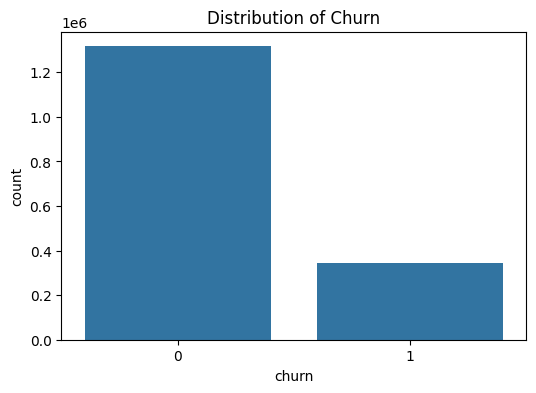

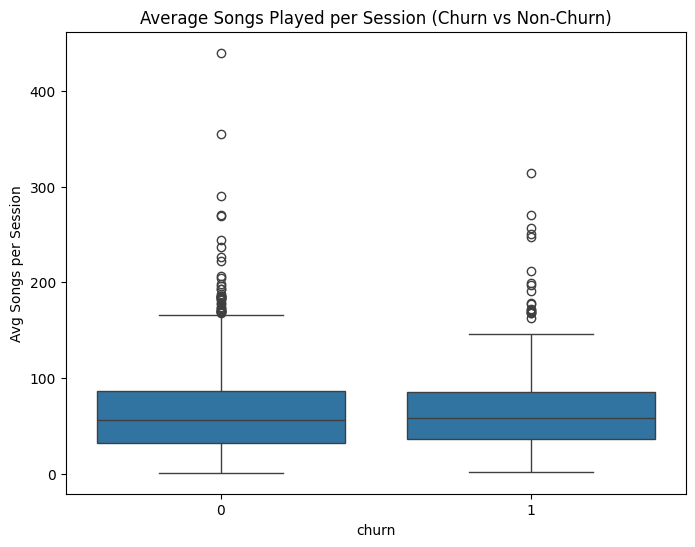

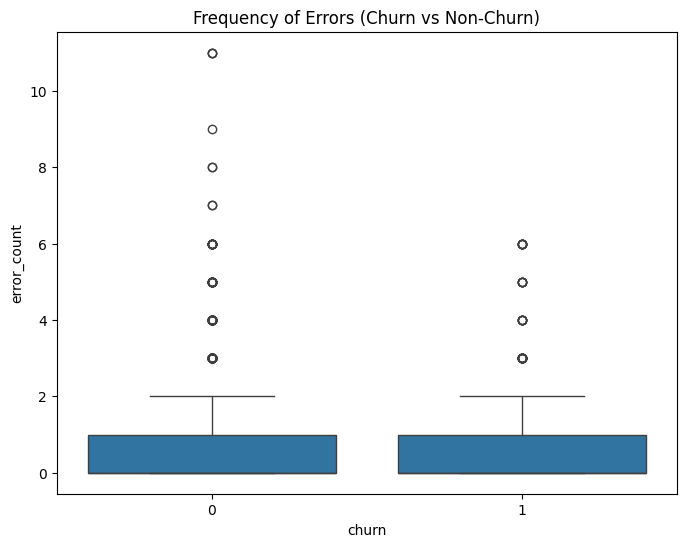

In [7]:
# Plot distribution of Churn
plt.figure(figsize=(6, 4))
sb.countplot(x='churn', data=df)
plt.title('Distribution of Churn')
plt.show()

# Average songs played per session for Churners vs. Non-Churners
# First, identify songs (page == 'NextSong')
songs_df = df[df['page'] == 'NextSong']

# Group by userId and sessionId to count songs per session
songs_per_session = songs_df.groupby(['userId', 'sessionId']).size().reset_index(name='songs_count')

# Merge with churn info
user_churn_map = df[['userId', 'churn']].drop_duplicates()
songs_per_session = songs_per_session.merge(user_churn_map, on='userId')

# Calculate average songs per session for each user
avg_songs_user = songs_per_session.groupby(['userId', 'churn'])['songs_count'].mean().reset_index()

# Plot
plt.figure(figsize=(8, 6))
sb.boxplot(x='churn', y='songs_count', data=avg_songs_user)
plt.title('Average Songs Played per Session (Churn vs Non-Churn)')
plt.ylabel('Avg Songs per Session')
plt.show()

# Frequencies of errors
# Errors are likely page == 'Error'
errors_df = df[df['page'] == 'Error']
error_counts = errors_df.groupby('userId').size().reset_index(name='error_count')
error_counts = error_counts.merge(user_churn_map, on='userId', how='right').fillna(0)

plt.figure(figsize=(8, 6))
sb.boxplot(x='churn', y='error_count', data=error_counts)
plt.title('Frequency of Errors (Churn vs Non-Churn)')
plt.show()

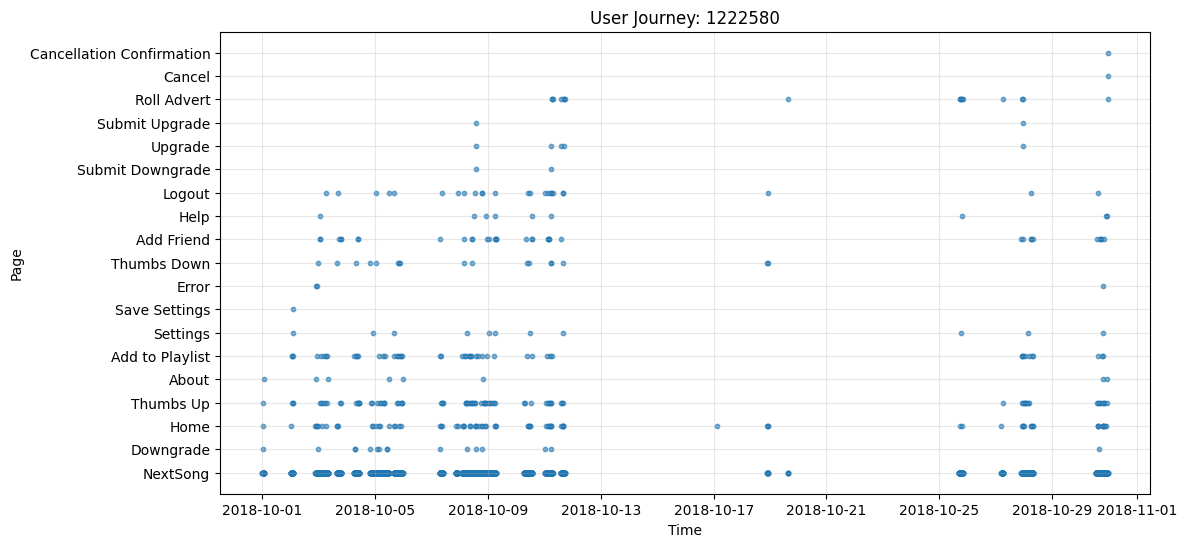

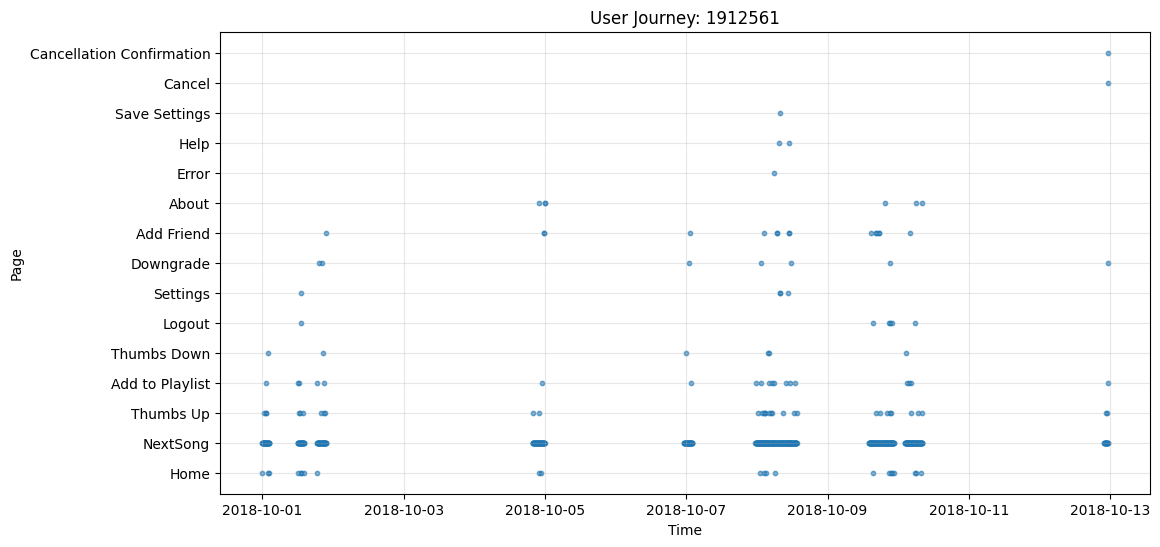

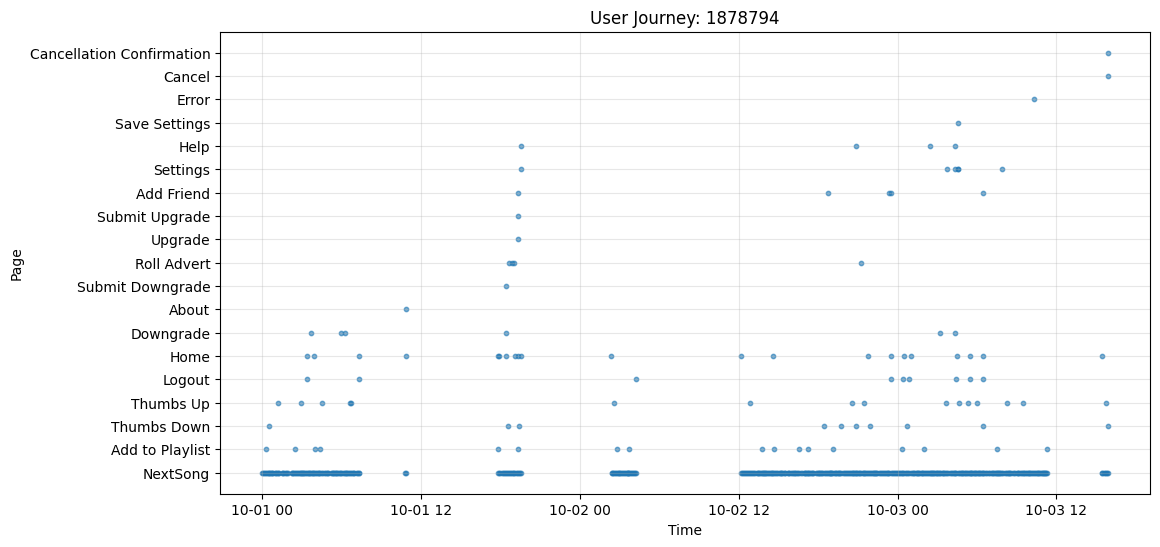

In [8]:
# Visualization of standard users journey to churn
# Pick a few churn users
if len(churn_users) > 0:
    sample_churn_users = churn_users[:3] # Take first 3
    
    for uid in sample_churn_users:
        user_data = df[df['userId'] == uid].sort_values('ts')
        
        # Plot events over time
        plt.figure(figsize=(12, 6))
        # We can map pages to y-axis values for better visualization or just use scatter
        # Since there are many pages, let's just plot the sequence
        plt.scatter(user_data['ts'], user_data['page'], alpha=0.6, s=10)
        plt.title(f'User Journey: {uid}')
        plt.xlabel('Time')
        plt.ylabel('Page')
        plt.grid(True, alpha=0.3)
        plt.show()
else:
    print("No churn users found to visualize.")